# DualPol Demo

<b>Author</b><br>
Timothy Lang, NASA MSFC<br>
timothy.j.lang@nasa.gov

<b>Overview</b><br>
DualPol is a software module that works in Python 2 or 3. It provides a workflow for using CSU_RadarTools and Py-ART together to perform all-in-one retrievals from polarimetric radar data.

Before getting started, you will need to install the following:
<ul>
<li>A robust version of Python 2.7 or 3.4 (other versions untested) w/ most standard scientific packages (e.g., numpy, matplotlib, pandas, etc.) - Get one for free here: https://store.continuum.io/cshop/anaconda/</li>
<li>The Python Atmospheric Radiation Measurement (ARM) Radar Toolkit (Py-ART; https://github.com/ARM-DOE/pyart)</li>
<li>CSU_RadarTools (https://github.com/CSU-Radarmet/CSU_RadarTools)
<li>SkewT (https://pypi.python.org/pypi/SkewT) - a Python 3 version can be found here: https://github.com/tjlang/SkewT</li>
</ul>

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pyart
import dualpol
import time
from copy import deepcopy
%matplotlib inline

Let's define where the sample data can be found.

In [2]:
fdir = '/Users/tjlang/Documents/OVWST/CPOL/output/20060119/'
files = sorted(glob.glob(fdir+'*nc'))
for file in files:
    print(os.path.basename(file))
radar = pyart.io.read(files[0])
print(radar.fields.keys())

cfrad.20060119_170029.000_to_20060121_020810.000_CPOL_v1_PPI.nc
cfrad.20060119_170029.000_to_20060121_020810.000_CPOL_v1_PPI.nc_evad_rdy.nc
[u'AD', u'KD', u'ZD', u'AH', u'DC', u'ZC', u'VR', u'DZ', u'FL', u'SR', u'PF', u'PH', u'RH', u'HD']


And now we can execute the dualpol retrievals with one (albeit long) line of code:

In [3]:
sndfile = '/Users/tjlang/Documents/OVWST/CPOL/soundings/snd_Darwin.txt'
retrieve = dualpol.DualPolRetrieval(files[0], dz='ZC', dr='ZD', kd='KD', rh='RH',
                                    use_temp=True, band='C', fhc_method='hybrid', 
                                    sounding=sndfile, fhc_T_factor=2,
                                    ice_flag=True, rain_method='hidro')

8.66256999969 seconds to do FHC


Let's print out the fields again to see what all was added:

In [4]:
print(retrieve.radar.fields.keys())

[u'DC', u'DZ', 'FH', u'FL', u'HD', 'temperature', u'PF', u'PH', u'RH', 'method', 'NW', u'AD', u'ZD', u'AH', 'rain', u'ZC', u'VR', u'KD', u'SR', 'MI', 'MU', 'MW', 'D0']


And now a quick plot to show the results. Note how dualpol provides special color tables to simplify plotting of hydrometeor ID and rainfall method information.

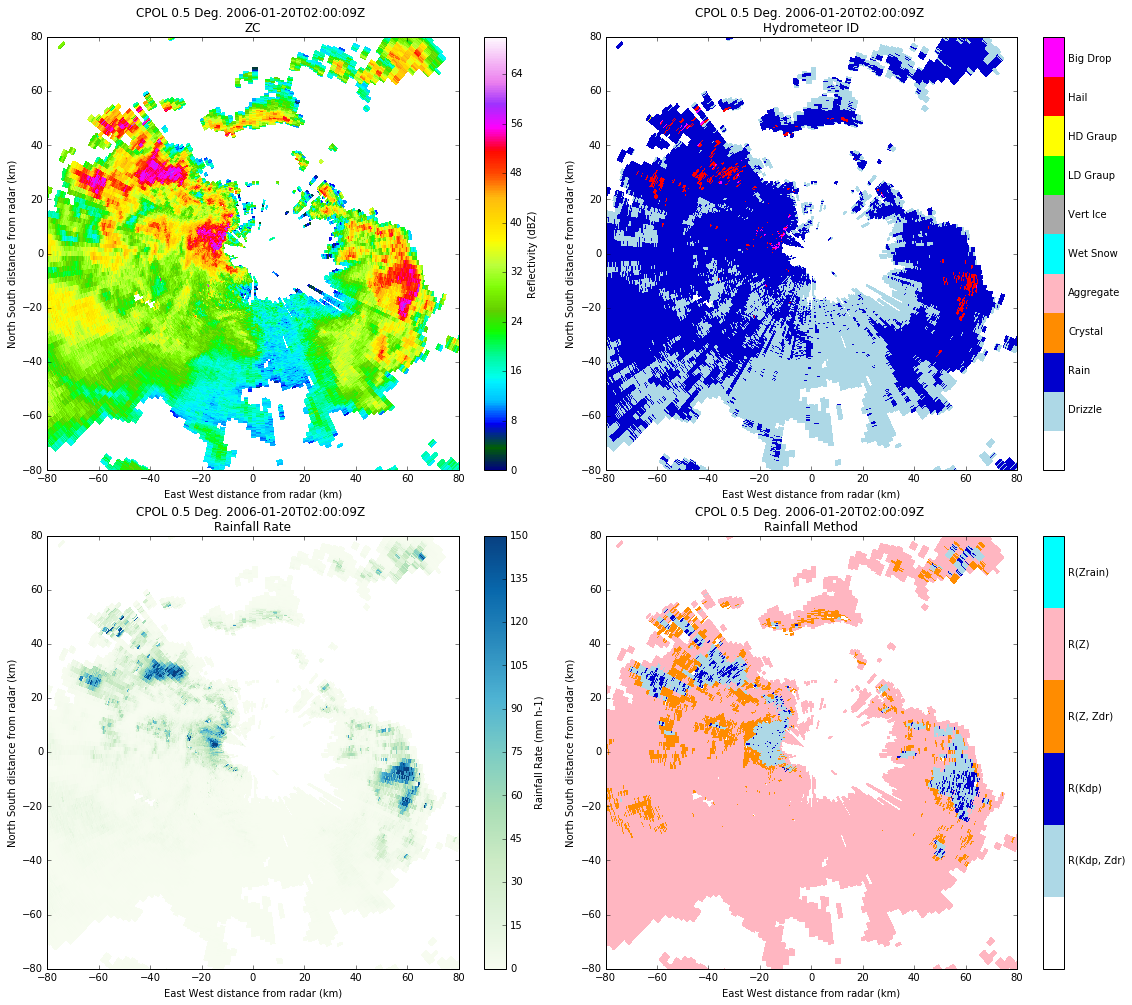

In [5]:
display = pyart.graph.RadarDisplay(retrieve.radar)
swp = 0
lim = [-80, 80]
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(221)
display.plot_ppi('ZC', swp, vmin=0, vmax=70, cmap='gist_ncar')
display.cbs[0].ax.set_ylabel('Reflectivity (dBZ)')
display.set_limits(xlim=lim, ylim=lim)
ax2 = fig.add_subplot(222)
hidcolor = dualpol.HidColors()
display.plot_ppi('FH', swp, vmin=0, vmax=10, cmap=hidcolor.cmaphid)
display.cbs[1] = hidcolor.adjust_fhc_colorbar_for_pyart(display.cbs[1])
display.set_limits(xlim=lim, ylim=lim)
ax3 = fig.add_subplot(223)
display.plot_ppi('rain', swp, vmin=0, vmax=150, cmap='GnBu')
display.set_limits(xlim=lim, ylim=lim)
ax4 = fig.add_subplot(224)
display.plot_ppi('method', swp, vmin=0, vmax=5, cmap=hidcolor.cmapmeth)
display.cbs[3] = hidcolor.adjust_meth_colorbar_for_pyart(display.cbs[3])
display.set_limits(xlim=lim, ylim=lim)
plt.tight_layout()

### Doing QC

DualPol can also perform basic quality control of the data, before applying all the retrievals. Simply change the qc_flag keyword to True. Then the reflectivity field's mask will be permanently changed. First let's plot what the data look like to start ...

In [6]:
nexrad_path = './20140605/'
nexrad_files = sorted(glob.glob(nexrad_path+'*.nc'))
print([os.path.basename(filen) for filen in nexrad_files])

['cfrad.20140605_050118.335_to_20140605_050429.410_KGSP_v669_SUR.nc']


In [7]:
nexrad = pyart.io.read(nexrad_files[0])
print(nexrad.fields.keys())

[u'PHI', u'REF_s1', u'REF_s5', u'REF_s3', u'SW', u'ZDR', u'RHO', u'VEL', u'REF']


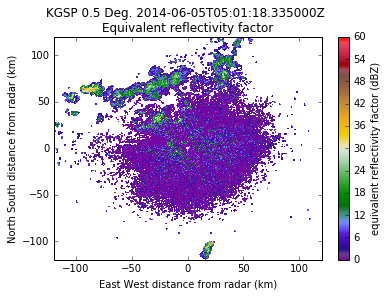

In [8]:
lim = [-120, 120]
swp = 0
display = pyart.graph.RadarDisplay(nexrad)
display.plot_ppi('REF', swp, vmin=0, vmax=60, cmap='pyart_Carbone42')
display.set_limits(xlim=lim, ylim=lim)

Obviously, all those insects are going to impact retrievals, so let's run DualPol and mask them out. Since this will permanently affect the mask of the reflectivity field, let's make a copy of it before running.

In [9]:
zc = deepcopy(nexrad.fields['REF']['data'])
nexrad.add_field_like('REF', 'ZC', zc, replace_existing=True)
sndfile = \
    '/Users/tjlang/Documents/PMM/IPHEX/DataFusion/20140605/snd_gso_20140605_0000z.txt'
begin_time = time.time()
retrieve = dualpol.DualPolRetrieval(
    nexrad, dz='ZC', dr='ZDR', dp='PHI', rh='RHO', use_temp=True,
    sounding=sndfile, fhc_T_factor=2, kdp_window=5,
    ice_flag=True, rain_method='hidro', qc_flag=True, gs=250.0, verbose=True,
    thresh_sdp=20.0, speckle=3)
print(time.time()-begin_time, 'seconds to run retrievals')

Not provided LDR field, not using
Not provided KDP field, calculating
Calculating KDP via CSU method
0.594510793686 seconds to run csu_kdp
Trying to get radar_T
Performing QC
Masking insects and high SDP, Despeckling
Performing FHC
USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 1, 'DZ': 1, 'T': 1, 'DR': 1}
-->get_mbf_sets_summer   10 Category Summer S-band HID
-->get_mbf_sets_summer  Using Temperature in HID
Using T in FHC
Using hybrid HID method. Pol vars weighted, Z and T (if used) are multiplied
weight_sum:  2.6
(10, 5040, 1832)
mu max:  1.0
40.1225070953 seconds to do FHC
Performing precip rate calculations
Performing DSD calculations
Performing mass calculations
60.1356158257 seconds to run retrievals


The code is pretty slow when FHC calculations are required. Expect to wait a minute or two.

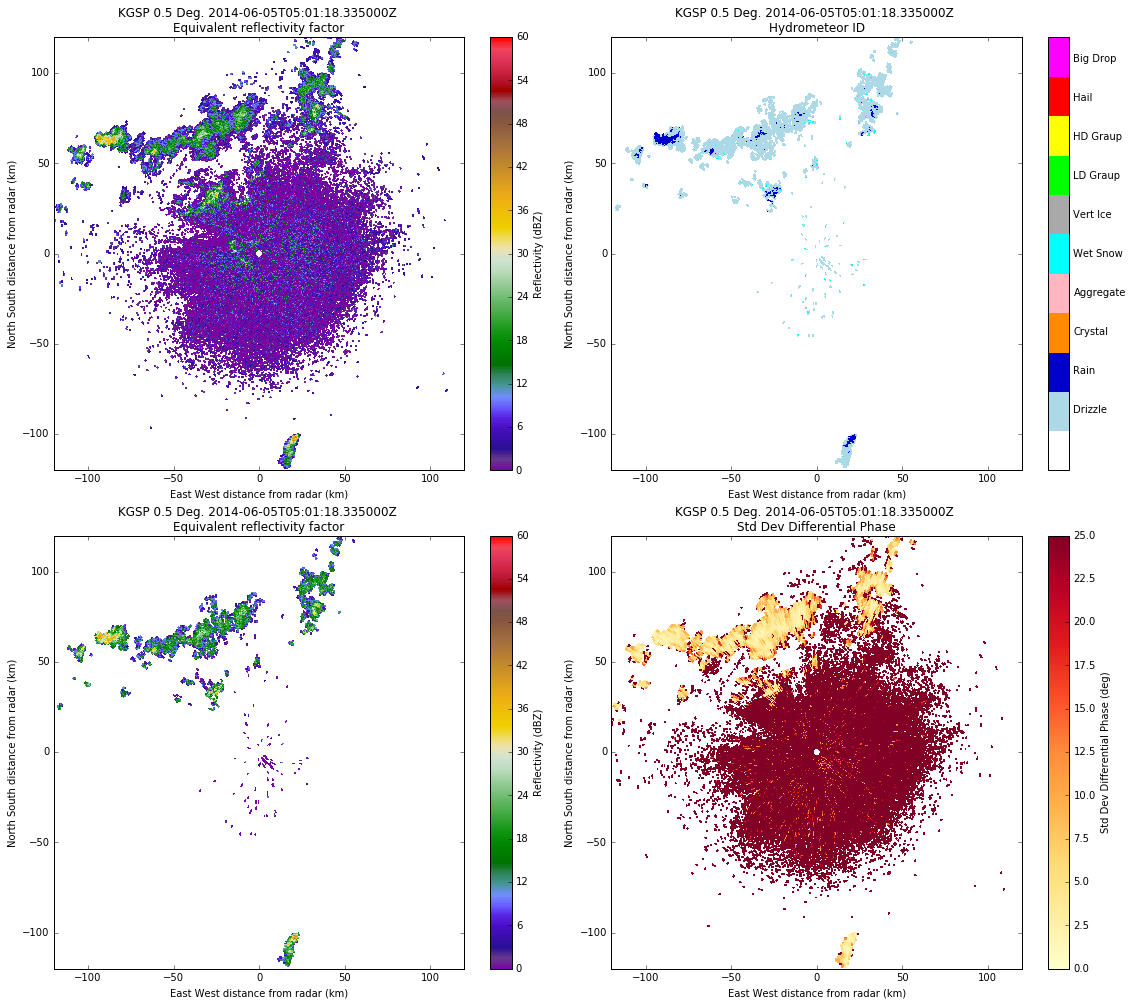

In [10]:
display = pyart.graph.RadarDisplay(retrieve.radar)
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(221)
display.plot_ppi('REF', swp, vmin=0, vmax=60, cmap='pyart_Carbone42')
display.cbs[0].ax.set_ylabel('Reflectivity (dBZ)')
display.set_limits(xlim=lim, ylim=lim)
ax2 = fig.add_subplot(222)
hidcolor = dualpol.HidColors()
display.plot_ppi('FH', swp, vmin=0, vmax=10, cmap=hidcolor.cmaphid)
display.cbs[1] = hidcolor.adjust_fhc_colorbar_for_pyart(display.cbs[1])
display.set_limits(xlim=lim, ylim=lim)
ax3 = fig.add_subplot(223)
display.plot_ppi('ZC', swp, vmin=0, vmax=60, cmap='pyart_Carbone42')
display.cbs[2].ax.set_ylabel('Reflectivity (dBZ)')
display.set_limits(xlim=lim, ylim=lim)
ax4 = fig.add_subplot(224)
display.plot_ppi('SDP_CSU', swp, vmin=0, vmax=25, cmap='YlOrRd')
display.set_limits(xlim=lim, ylim=lim)
plt.tight_layout()

Changing the thresh_sdp, speckle, dz_range, and thresh_dr keywords can vary the filtering level as needed. See the csu_radartools.csu_misc module and DualPol source code for more information on how these filters are used.

If you are happy with these mask changes, you can apply them to other fields, for example:

In [11]:
mask1 = getattr(retrieve.radar.fields['ZC']['data'], 'mask')
mask2 = getattr(retrieve.radar.fields['VEL']['data'], 'mask')
mask = np.logical_or(mask1, mask2)
ve = deepcopy(retrieve.radar.fields['VEL']['data'])
retrieve.radar.add_field_like('VEL', 'VE', ve, replace_existing=True)
setattr(retrieve.radar.fields['VE']['data'], 'mask', mask)

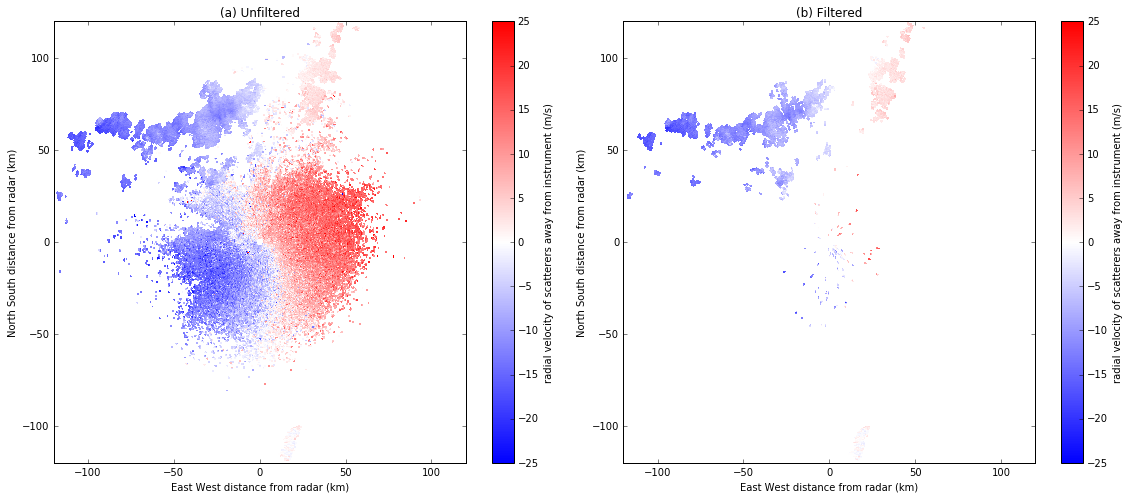

In [12]:
swp = 0
display = pyart.graph.RadarDisplay(retrieve.radar)
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121)
display.plot_ppi('VEL', swp, vmin=-25, vmax=25,
                 cmap='bwr', title='(a) Unfiltered')
display.set_limits(xlim=lim, ylim=lim)
ax2 = fig.add_subplot(122)
display.plot_ppi('VE', swp, vmin=-25, vmax=25, cmap='bwr',
                 title='(b) Filtered')
display.set_limits(xlim=lim, ylim=lim)
plt.tight_layout()

As we sign off, let's print out the main DualPol docstring to find out more info.

In [14]:
help(dualpol.DualPolRetrieval)

Help on class DualPolRetrieval in module dualpol.dualpol:

class DualPolRetrieval(__builtin__.object)
 |  Class that wraps all the dual-polarization retrievals powered by
 |  CSU_RadarTools.
 |  
 |  Brief overview of DualPolRetrieval structure
 |  --------------------------------------------
 |  Main attributes of interest is radar, which is the original Py-ART radar
 |  object provided to DualPolRetrieval. DualPolRetrieval.radar contains
 |  new fields based on what the user wanted DualPolRetrieval to do.
 |  
 |  New fields that can be in DualPolRetrieval.radar.fields:
 |  'FH' (or whatever user provided in name_fhc kwarg) = HID
 |  'FI' = Ice Fraction
 |  'ZDP' = Difference Reflectivity
 |  'KDP_CSU' = KDP as calculated by CSU_RadarTools
 |  'FDP_CSU' = Filtered differential phase
 |  'SDP_CSU' = Standard deviation of differential phase
 |  'MI' = Mass of ice
 |  'MW' = Mass of liquid water
 |  'rain' = Rainfall rate
 |  'method' = Rainfall method used
 |  'D0' = Median Volume Diam